In [32]:
import concurrent.futures

import numpy as np
import pandas as pd
import pandas_datareader.data as web

# metrics
from sklearn.metrics import *

# visuals.
import seaborn as sns

In [37]:
TRADES_DATE = "2021-02-01"
FUTURE_DATE = "2021-02-03"

year, month, day = TRADES_DATE.split("-")
trades = pd.read_csv(f"./trades/ARK_Trade_{''.join([month, day, year])}_0619PM_EST_601875e069e08.csv").dropna(how='all')
trades.rename({"FUND":"etf", "Direction":"direction", "Ticker":"symbol", "% of ETF":"pct_etf"}, axis=1, inplace=True)
trades.head(3)

,etf,Date,direction,symbol,CUSIP,Name,Shares,pct_etf
0,ARKQ,2021-02-01,Buy,LMT,539830109,LOCKHEED MARTIN CORP,47673.0,0.5146
1,ARKQ,2021-02-01,Buy,NVDA,67066G104,NVIDIA CORP,28521.0,0.5020
2,ARKW,2021-02-01,Buy,DKNG,26142R104,DRAFTKINGS INC,620300.0,0.5007


In [38]:
configs = [{"symbol":symbol, "date":TRADES_DATE, "on":"Adj Close"} for symbol in trades["symbol"].unique()] # on ark's trade date
configs.extend([{"symbol":symbol, "date":FUTURE_DATE, "on":"Adj Close"} for symbol in trades["symbol"].unique()]) # future date

def parallel_fetch_daily_data(config):
    # fetch daily market data from yahoo finance
    df = web.get_data_yahoo(config["symbol"], start=config["date"], end=config["date"])[[config["on"]]]
    df["symbol"] = config["symbol"]
    return df


prices = [] # list of dfs
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    prices.extend(executor.map(parallel_fetch_daily_data, configs))
prices = pd.concat(prices)
prices

,Adj Close,symbol
Date,,
2021-02-01,324.029999,LMT
2021-02-01,529.479980,NVDA
2021-02-01,54.639999,DKNG
2021-02-01,416.200012,ROKU
2021-02-01,109.669998,FSLY
2021-02-01,126.660004,TSM
2021-02-01,53.790001,SPCE
2021-02-01,117.550003,TER
2021-02-01,68.129997,MTLS


In [55]:
returns = [] # actual price changes
gg = prices.groupby("symbol")
for g in gg.groups:
    gdf = gg.get_group(g)
    symbol_return = gdf["Adj Close"].pct_change().loc[FUTURE_DATE]
    returns.append({
        "symbol":g,
        "return":symbol_return,
        "direction":"Buy" if symbol_return>0 else "Sell"
    })
returns = pd.DataFrame(returns)
returns

,symbol,return,direction
0,API,0.233288,Buy
1,AVAV,0.021519,Buy
2,BEAM,0.011693,Buy
3,BEKE,0.034279,Buy
4,BYDDY,0.056765,Buy
5,CDXS,0.170640,Buy
6,DKNG,0.100110,Buy
7,FATE,0.054530,Buy
8,FLIR,0.013863,Buy
9,FSLY,0.001459,Buy


In [56]:
trades_sginal = [] # signals based on ARK trades
tgg = trades.groupby("symbol")
for g in tgg.groups:
    gdf = tgg.get_group(g)
    trades_sginal.append({
        "symbol":g,
        "direction":gdf["direction"].mode()[0]
    })
trades_sginal = pd.DataFrame(trades_sginal)
trades_sginal.head()

,symbol,direction
0,API,Sell
1,AVAV,Sell
2,BEAM,Buy
3,BEKE,Buy
4,BYDDY,Sell


In [57]:
trades_sginal.sort_values("symbol", inplace=True)
returns.sort_values("symbol", inplace=True)
if set(trades_sginal["symbol"]) != set(returns["symbol"]):
    raise ValueError("symbols do not match")
    
actual = np.array(returns["direction"])
signal = np.array(trades_sginal["direction"])

print(classification_report(actual, signal))

              precision    recall  f1-score   support

         Buy       1.00      0.40      0.57        25
        Sell       0.12      1.00      0.21         2

    accuracy                           0.44        27
   macro avg       0.56      0.70      0.39        27
weighted avg       0.93      0.44      0.54        27



In [58]:
joined = pd.merge(trades, returns, on="symbol", suffixes=("_signal", "_return"))
joined["pct_etf"] = joined.apply(lambda row : row["pct_etf"] if row["direction_signal"]=="Buy" else -row["pct_etf"], axis=1)
joined.head()

,etf,Date,direction_signal,symbol,CUSIP,Name,Shares,pct_etf,return,direction_return
0,ARKQ,2021-02-01,Buy,LMT,539830109,LOCKHEED MARTIN CORP,47673.0,0.5146,0.025800,Buy
1,ARKQ,2021-02-01,Buy,NVDA,67066G104,NVIDIA CORP,28521.0,0.5020,0.022173,Buy
2,ARKW,2021-02-01,Buy,NVDA,67066G104,NVIDIA CORP,64133.0,0.4975,0.022173,Buy
3,ARKW,2021-02-01,Buy,DKNG,26142R104,DRAFTKINGS INC,620300.0,0.5007,0.100110,Buy
4,ARKW,2021-02-01,Sell,ROKU,77543R102,ROKU INC,73244.0,-0.4403,0.021312,Buy


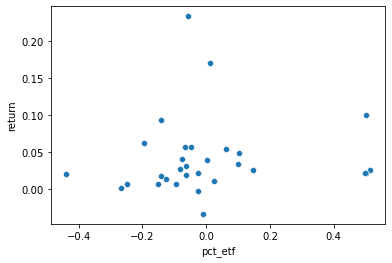

In [59]:
sns.scatterplot(x=joined["pct_etf"], y=joined["return"])

In [60]:
joined.corr()

,Shares,pct_etf,return
Shares,1.000000,0.243674,0.197300
pct_etf,0.243674,1.000000,0.076343
return,0.197300,0.076343,1.000000
